# Supervised Model

### Import Libraries

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_path = "../OCT2017 /train/"
test_path = "../OCT2017 /test/"
valid_path = "../OCT2017 /val/"

In [3]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

### Display images

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(valid_path)

Found 32 files belonging to 4 classes.


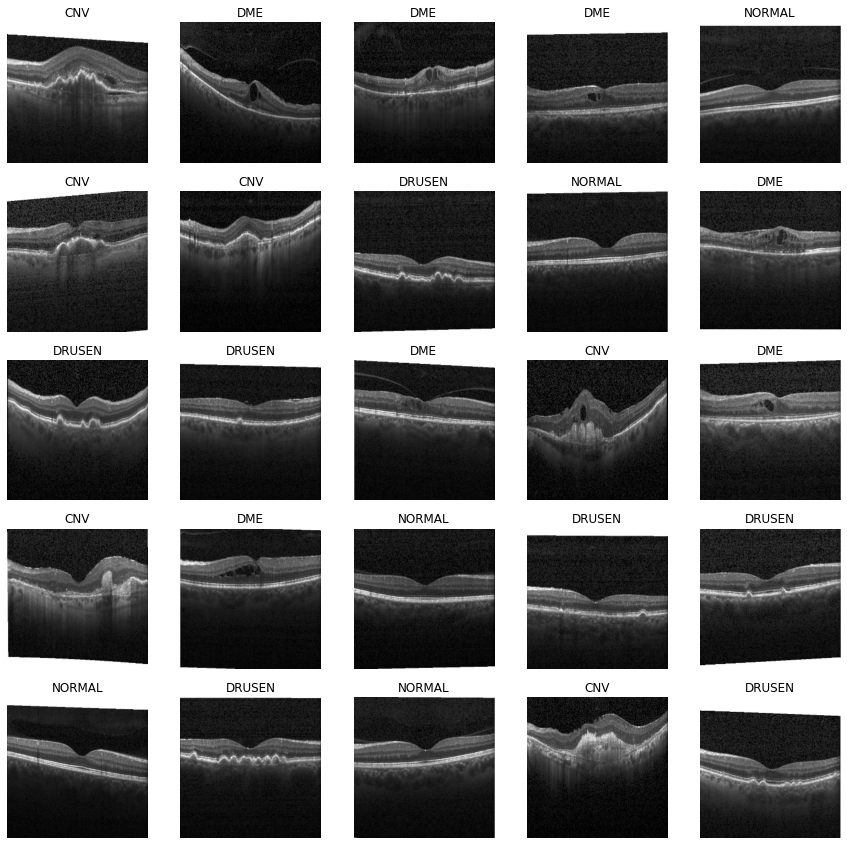

In [65]:
class_names = train_ds.class_names

plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        validation_split = 0.012)
test_gen = keras.preprocessing.image.ImageDataGenerator()

In [6]:
train_batches = train_gen.flow_from_directory(train_path,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE,
                                              subset = 'training',
                                              class_mode = "categorical",
                                              seed = 26)

test_batches = test_gen.flow_from_directory(test_path,
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical")

valid_batches = train_gen.flow_from_directory(train_path,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE,
                                              subset = 'validation',
                                              class_mode = "categorical",
                                              seed = 26)

Found 82484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


### VGG16 MODEL 

In [36]:
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape = (224,224,3),
                                                     include_top = False,
                                                     weights = 'imagenet')

pretrained_model.trainable = False

In [37]:
model1 = Sequential()
model1.add(pretrained_model)
model1.add(GlobalAveragePooling2D())
#model1.add(Flatten())
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='softmax'))

In [38]:
vgg16 = model1

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

vgg16.compile(loss='categorical_crossentropy',
              optimizer= optim,
              metrics=metrics)

vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
epochs = 3

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=3)

In [31]:
vgg16.fit(train_batches, 
          validation_data = valid_batches,
          callbacks = [early_stopping],
          #steps_per_epoch = train_batches.samples // BATCH_SIZE,
          epochs = epochs)

Epoch 1/3
1285/1285 [==============================] - 408s 317ms/step - loss: 0.8585 - accuracy: 0.6977 - val_loss: 0.6875 - val_accuracy: 0.7714
Epoch 2/3
1285/1285 [==============================] - 399s 310ms/step - loss: 0.6307 - accuracy: 0.7778 - val_loss: 0.5754 - val_accuracy: 0.8058
Epoch 3/3
1285/1285 [==============================] - 399s 310ms/step - loss: 0.5577 - accuracy: 0.8022 - val_loss: 0.5217 - val_accuracy: 0.8297


**80.2% accuracy after 3 epochs.**

In [101]:
vgg16.save("../Models/vgg16_initial.h5")

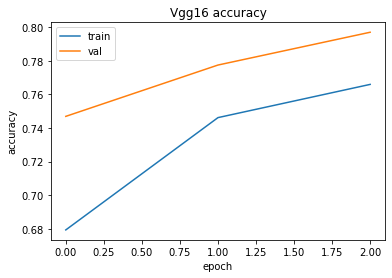

In [102]:
plt.plot(vgg16.history.history['accuracy'])
plt.plot(vgg16.history.history['val_accuracy'])
plt.title('Vgg16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

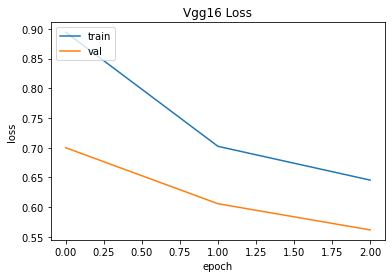

In [103]:
plt.plot(vgg16.history.history['loss'])
plt.plot(vgg16.history.history['val_loss'])
plt.title('Vgg16 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
vgg16_load = keras.models.load_model("../Models/vgg16_initial.h5")

In [33]:
vgg16.evaluate(test_batches)

16/16 [==============================] - 6s 350ms/step - loss: 18.5882 - accuracy: 0.5227


[18.58820915222168, 0.5227272510528564]

**52.2% Test Accuracy**

### InceptionV3 Model

In [9]:
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224,224,3),
                                                                  include_top = False,
                                                                  weights = 'imagenet')

pretrained_model.trainable = False

2022-06-20 23:23:38.999630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 23:23:39.190205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 23:23:39.190959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 23:23:39.193797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
model2 = Sequential()
model2.add(pretrained_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))

In [11]:
inception_v3 = model2

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

inception_v3.compile(loss='categorical_crossentropy',
                    optimizer= optim,
                    metrics=metrics)

inception_v3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [109]:
epochs = 3

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=3)

In [110]:
inception_v3.fit(train_batches, validation_data = valid_batches,
         callbacks = [early_stopping],
         epochs = epochs)

Epoch 1/3
1175/1175 [==============================] - 297s 250ms/step - loss: 0.4830 - accuracy: 0.8261 - val_loss: 0.4455 - val_accuracy: 0.8464
Epoch 2/3
1175/1175 [==============================] - 297s 253ms/step - loss: 0.3914 - accuracy: 0.8603 - val_loss: 0.4064 - val_accuracy: 0.8538
Epoch 3/3
1175/1175 [==============================] - 297s 252ms/step - loss: 0.3681 - accuracy: 0.8688 - val_loss: 0.3960 - val_accuracy: 0.8592


**86.8%** accuracy after 3 epochs.

In [111]:
inception_v3.save("../Models/inceptionv3_initial.h5")

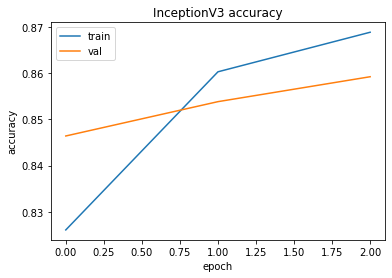

In [112]:
plt.plot(inception_v3.history.history['accuracy'])
plt.plot(inception_v3.history.history['val_accuracy'])
plt.title('InceptionV3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

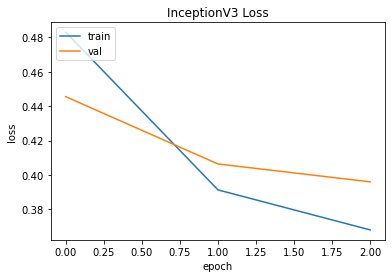

In [113]:
plt.plot(inception_v3.history.history['loss'])
plt.plot(inception_v3.history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [114]:
inceptionv3_load = keras.models.load_model("../Models/inceptionv3_initial.h5")

In [115]:
inceptionv3_load.evaluate(test_batches)

16/16 [==============================] - 5s 169ms/step - loss: 88.7325 - accuracy: 0.2645


[88.73253631591797, 0.26446279883384705]

**26.4% Test Accuracy**

### Resnet50 Model

In [48]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(input_shape = (224,224,3),
                                                                  include_top = False,
                                                                  weights = 'imagenet')

pretrained_model.trainable = False

In [49]:
model3 = Sequential()
model3.add(pretrained_model)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.2))
model3.add(Dense(4, activation='softmax'))

In [50]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [51]:
Resnet50 = model3

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

Resnet50.compile(loss='categorical_crossentropy',
                    optimizer= optim,
                    metrics=metrics)

Resnet50.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [52]:
epochs = 3

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=5)

In [53]:
Resnet50.fit(train_batches, validation_data = valid_batches,
         callbacks = [early_stopping],
         epochs = epochs)

Epoch 1/3
1175/1175 [==============================] - 304s 255ms/step - loss: 1.1787 - accuracy: 0.5202 - val_loss: 1.0996 - val_accuracy: 0.6000
Epoch 2/3
1175/1175 [==============================] - 299s 255ms/step - loss: 1.1138 - accuracy: 0.5648 - val_loss: 1.0537 - val_accuracy: 0.6245
Epoch 3/3
1175/1175 [==============================] - 298s 253ms/step - loss: 1.0921 - accuracy: 0.5782 - val_loss: 1.0287 - val_accuracy: 0.6324


**57.8%** Training accuracy after 3 epochs

In [54]:
Resnet50.save("../Models/Resnet50_initial3.h5")

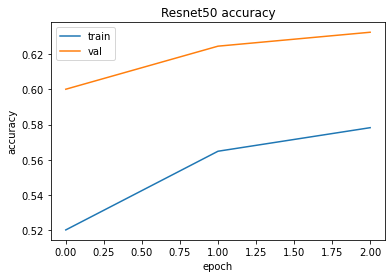

In [55]:
plt.plot(Resnet50.history.history['accuracy'])
plt.plot(Resnet50.history.history['val_accuracy'])
plt.title('Resnet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

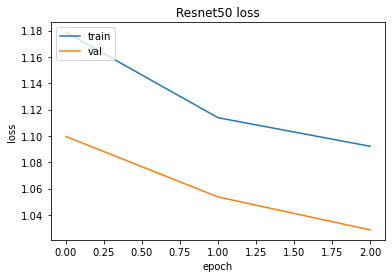

In [56]:
plt.plot(Resnet50.history.history['loss'])
plt.plot(Resnet50.history.history['val_loss'])
plt.title('Resnet50 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
Resnet50_load = keras.models.load_model("../Models/Resnet50_initial3.h5")

In [74]:
Resnet50_load.evaluate(test_batches)

16/16 [==============================] - 6s 209ms/step - loss: 59.8769 - accuracy: 0.2500


[59.87694549560547, 0.25]

**25% Test Accuracy**

### Training FULL - Inception V3

In [44]:
epochs = 20

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=3)

In [45]:
inception_v3.fit(train_batches, 
                 validation_data = valid_batches,
                 callbacks = [early_stopping],
                 epochs = epochs)

Epoch 1/20
1289/1289 [==============================] - 306s 233ms/step - loss: 0.5225 - accuracy: 0.8085 - val_loss: 0.4449 - val_accuracy: 0.8480
Epoch 2/20
1289/1289 [==============================] - 295s 229ms/step - loss: 0.4465 - accuracy: 0.8391 - val_loss: 0.4490 - val_accuracy: 0.8380
Epoch 3/20
1289/1289 [==============================] - 296s 230ms/step - loss: 0.4356 - accuracy: 0.8431 - val_loss: 0.4755 - val_accuracy: 0.8300
Epoch 4/20
1289/1289 [==============================] - 292s 226ms/step - loss: 0.4318 - accuracy: 0.8440 - val_loss: 0.4288 - val_accuracy: 0.8530
Epoch 5/20
1289/1289 [==============================] - 292s 226ms/step - loss: 0.4338 - accuracy: 0.8444 - val_loss: 0.4073 - val_accuracy: 0.8470
Epoch 6/20
1289/1289 [==============================] - 293s 227ms/step - loss: 0.4253 - accuracy: 0.8464 - val_loss: 0.4333 - val_accuracy: 0.8370
Epoch 7/20
1289/1289 [==============================] - 293s 227ms/step - loss: 0.4292 - accuracy: 0.8456 - val_

**84.6% Training Accuracy**

In [46]:
inception_v3.save("../Models/inception_v3.h5")

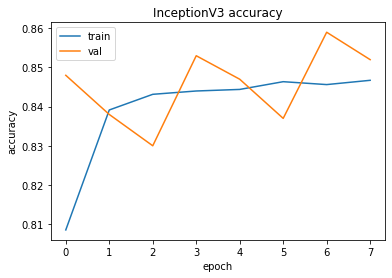

In [47]:
plt.plot(inception_v3.history.history['accuracy'])
plt.plot(inception_v3.history.history['val_accuracy'])
plt.title('InceptionV3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

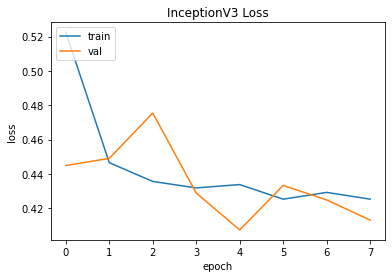

In [48]:
plt.plot(inception_v3.history.history['loss'])
plt.plot(inception_v3.history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
inception_v3.evaluate(test_batches)

31/31 [==============================] - 5s 126ms/step - loss: 85.4470 - accuracy: 0.2593


[85.447021484375, 0.25929751992225647]

only **26.7%** accuracy on test data

In [15]:
inceptionv3_load = keras.models.load_model("../Models/inception_v3.h5")

In [16]:
inceptionv3_load.evaluate(test_batches)

2022-06-20 23:26:37.158516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


16/16 [==============================] - 13s 277ms/step - loss: 76.0459 - accuracy: 0.2676


[76.04592895507812, 0.26756197214126587]